# Project team:
- Leon Rolvink (17103363)
- Lara van Veen (17054435)
- Matthijs van Vianen (16054334)
- Jelle Westra (16037197)

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from functools import reduce
from itertools import product
import time
import sys

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import joblib

# Assignment 1
Carefully read the competition description on Kaggle.com and execute the following tasks:
1.	Define the problem that Walmart wants you to solve.
2.	Describe the decisions that Walmart can take after the delivery of your work 

#### 1.1
What are the predicted sales per department per store, and how do different holidays influence these sales?

#### 1.2
When Walmart knows the amount of weekly sales per department per store, it can:
- Adapt their product procurement to better fit the products sold, and therefore reduce waste or the change of running out of stock. 
- Change staff schedules to accommodate the increase or decrease of inventory turnover and the busyness within the stores.
- Adapt nation-wide or regional promotions to fit within the current demand of the customer.


# Assignment 2 Collect raw data
1.	Create one profile for your team on Kaggle.com. Let us know what the username of your team is:
2.	Download the data set and upload the data set to the files folder in your MS Teams channel.

#### 2.1
- Team12Ninja 
- https://www.kaggle.com/team12ninja

# Assignment 3 Process the data 
1.	Import the data set into a Jupyter Notebook as dataframes
2.	Examine the data at a high level:
    a.	Understand every column
    b.	Identify errors, missing values & corrupt records (make sure to check this even though it’s quite a clean data set)
3.	Clean the data (make sure to check this even though it’s quite a clean data set)
    a.	Throw away, replace, filter corrupt/ error prone / missing values.
    
    
You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

#### stores.csv

This file contains anonymized information about the 45 stores, indicating the type and size of store.

#### train.csv

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

Store - the store number
Dept - the department number
Date - the week
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week

#### test.csv

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

#### features.csv

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week
For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## 3.2

### stores.csv

#### a 
Understand every column.

In [35]:
df_stores = pd.read_csv('data/stores.csv')
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [36]:
df_stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


Colomns:
- `Store` Store number.
- `Type` Type of store, either A, B, and C.
- `Size` Size of the store.

#### b
Identify errors, missing values & corrupt records.

In [37]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


There are no missing values.

In [38]:
df_stores['Store'].nunique() == len(df_stores)

True

All store numbers are unique.

In [39]:
df_stores['Type'].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

Store type can only be either A, B or C.

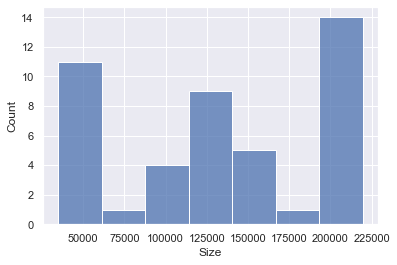

In [40]:
sns.histplot(df_stores, x='Size');

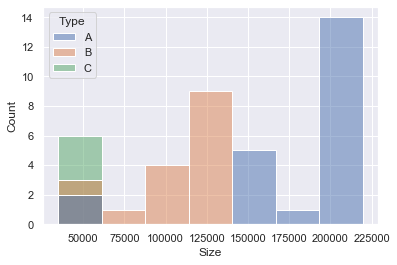

In [41]:
sns.histplot(df_stores, x='Size', hue='Type');

There are no clear outliers in size. Store of type "A" seems to be bigger in general. Store "B" seem to be a mid-size store and type "C" a small-size store.

### train.csv

#### a 
Understand every column.

In [42]:
df_train = pd.read_csv('data/train.csv', parse_dates=['Date'])
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [43]:
df_train['Date'].dtype

dtype('<M8[ns]')

Colomns:
- `Store` Store number.
- `Dept` Department number.
- `Date` The date of the week.
- `Weekly_Sales` Sales for the given department in the given store.
- `IsHoliday` Whether the week is a special holiday week

#### b
Identify errors, missing values & corrupt records.

In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


There are no missing values.

##### Store

In [45]:
np.all(df_train['Store'].unique() == df_stores['Store'].unique())

True

All stores from stores.csv are in the training set.

##### Dept

In [46]:
np.sort(df_train['Dept'].unique()).size

81

In [47]:
np.sort(df_train['Dept'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82,
       83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64)

Number of unique departments for store 1 and 2:

In [48]:
df_train[df_train['Store'] == 1]['Dept'].unique().size

77

In [49]:
df_train[df_train['Store'] == 2]['Dept'].unique().size

78

There are 81 different departments that are defined by numbers ranging from 1 to 99. Not all stores contain all departments.

##### Date

In [50]:
df_train[['Date']]

,Date
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
...,...
421565,2012-09-28
421566,2012-10-05
421567,2012-10-12
421568,2012-10-19


The date is already in international standard and has no errors.

##### Weekly_Sales

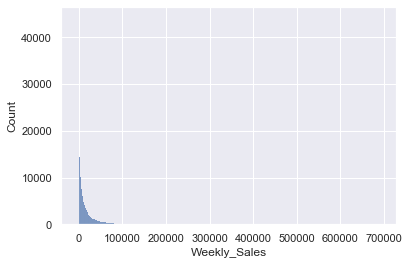

In [51]:
sns.histplot(df_train, x='Weekly_Sales');

In [52]:
df_train.sort_values('Weekly_Sales')

,Store,Dept,Date,Weekly_Sales,IsHoliday
267730,28,6,2010-10-08,-4988.94,False
336495,35,47,2011-09-02,-3924.00,False
417801,45,47,2010-02-26,-1750.00,False
153916,16,47,2012-03-09,-1699.00,False
271300,28,32,2011-03-25,-1321.48,False
...,...,...,...,...,...
135665,14,72,2010-11-26,474330.10,True
337961,35,72,2010-11-26,627962.93,True
95425,10,72,2011-11-25,630999.19,True
338013,35,72,2011-11-25,649770.18,True


In [53]:
# finding percetage of negative values in "Weekly_Sales"
(df_train['Weekly_Sales'] < 0).sum() / len(df_train['Weekly_Sales']) * 100

0.30481296107408024

There are negative values within Weekly_Sales, these are corrections of the previous week. As these negative sales only consist of 0.3% of the rows, these values are discarded. The outliers from Weekly_Sales on the maximum side are explained by the holidays in that week.

In [54]:
df_train = df_train[df_train['Weekly_Sales'] > 0]

##### IsHoliday

In [55]:
df_train['IsHoliday'].value_counts()

False    390652
True      29560
Name: IsHoliday, dtype: int64

There are no errors in is IsHoliday.

### test.csv

In [56]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [57]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
Store        115064 non-null int64
Dept         115064 non-null int64
Date         115064 non-null object
IsHoliday    115064 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


The file description stated that the test.csv is identical to train.csv, except the weekly sales are dropped. There are no missing values in test.csv.

### features.csv
#### a
Understand every column.

In [58]:
df_features = pd.read_csv('data/features.csv', parse_dates=['Date'])
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Columns: 
- `Store` Store number.
- `Date` The week.
- `Temperature` Average temperature in the region.
- `Fuel_Price` Cost of fuel in the region.
- `MarkDown1-5` Anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- `CPI` The consumer price index. 
- `Unemployment` The unemployment rate.
- `IsHoliday` Whether the week is a special holiday week For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

#### b
Identify errors, missing values & corrupt records.

In [59]:
df_features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

There are missing values in MarkDown1-5, CPI and Employment.

##### Stores

In [60]:
np.all(df_features['Store'].unique() == df_stores['Store'])

True

All stores from stores.csv are in the training set.

##### Date

In [61]:
df_features['Date'] = pd.to_datetime(df_features['Date'])

The date is already in international standard and converted to datetime object. The date colomn has no errors.

##### Temperature

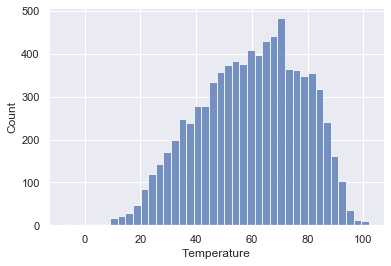

In [62]:
sns.histplot(df_features, x='Temperature');

In [63]:
df_features[['Temperature']].agg([np.min, np.max])

,Temperature
amin,-7.29
amax,101.95


The temperature follows a clean distribution. There are no abnormal values in Temperature. There are no missing values.

##### Fuel_Price

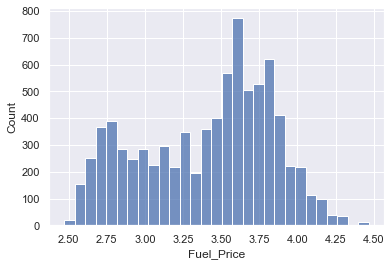

In [64]:
sns.histplot(df_features, x='Fuel_Price');

The range of the fuel price data seems reasonable. There are no missing values.

##### Markdown1-5

In [65]:
df_features[['Date', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']]

,Date,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
0,2010-02-05,NaN,NaN,NaN,NaN,NaN
1,2010-02-12,NaN,NaN,NaN,NaN,NaN
2,2010-02-19,NaN,NaN,NaN,NaN,NaN
3,2010-02-26,NaN,NaN,NaN,NaN,NaN
4,2010-03-05,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
8185,2013-06-28,4842.29,975.03,3.00,2449.97,3169.69
8186,2013-07-05,9090.48,2268.58,582.74,5797.47,1514.93
8187,2013-07-12,3789.94,1827.31,85.72,744.84,2150.36
8188,2013-07-19,2961.49,1047.07,204.19,363.00,1059.46


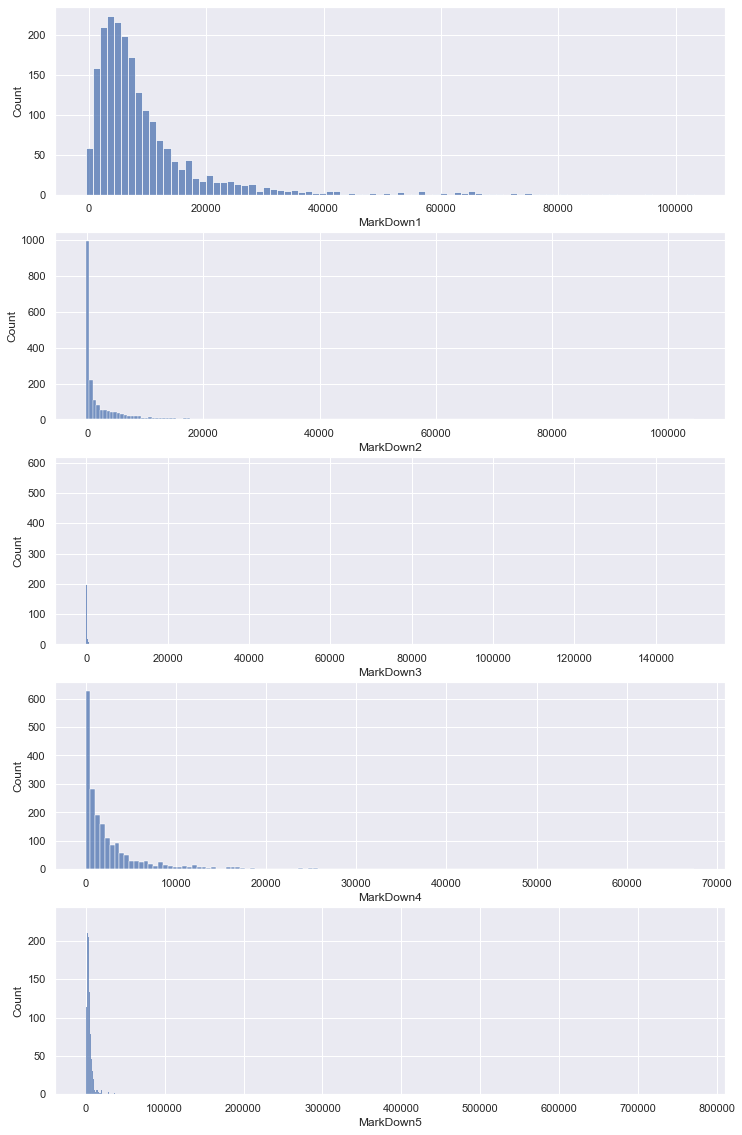

In [66]:
fig, ax = plt.subplots(5, 1, figsize=(12, 20))

for i in range(5):
    sns.histplot(df_features.dropna(), x='MarkDown%i' %(i+1), ax=ax[i]);

In [67]:
df_features['MarkDown1'].sort_values()

5437   -2781.45
6518    -772.21
4162    -563.90
6514     -16.93
6863       0.27
         ...   
8095        NaN
8096        NaN
8097        NaN
8098        NaN
8099        NaN
Name: MarkDown1, Length: 8190, dtype: float64

In [68]:
df_features['MarkDown1'].isna().value_counts()

True     4158
False    4032
Name: MarkDown1, dtype: int64

Half of the MarkDown information is missing, we will be dealing with this during the feature engineering. Also there are some negative MarkDowns, let's set those to `NaN` aswell.

In [69]:
for i in range(5):
    df_features.loc[df_features['MarkDown%i' %(i+1)] < 0, 'MarkDown%i' %(i+1)] = np.nan

##### CPI

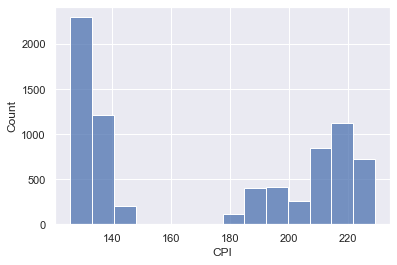

In [70]:
sns.histplot(df_features, x='CPI');

CPI doesn't follow a bell shaped distribution.

In [71]:
df_features[df_features['CPI'].isna()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
169,1,2013-05-03,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,NaN,NaN,False
170,1,2013-05-10,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,NaN,NaN,False
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,NaN,NaN,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


All the missing values of CPI are between 2013-05 and 2013-07.

In [72]:
df_features.groupby(df_features['Date'].dt.year)['CPI'].mean()

Date
2010    168.101782
2011    171.545716
2012    175.716621
2013    177.608807
Name: CPI, dtype: float64

Since the CPI is only missing in 2013, we can fill the `NaN`'s with the mean CPI of 2013.

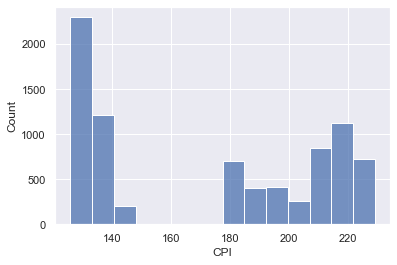

In [73]:
CPI_2013 = df_features.groupby(df_features['Date'].dt.year)['CPI'].mean().loc[2013]

df_features['CPI'] = df_features['CPI'].fillna(CPI_2013)

sns.histplot(df_features, x='CPI');

The distribution stays roughly the same.

##### Unemployment

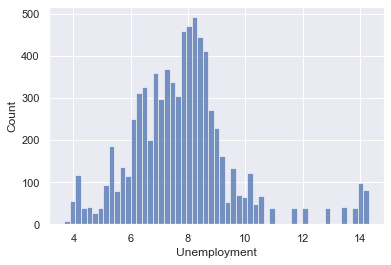

In [74]:
sns.histplot(df_features, x='Unemployment');

In [75]:
df_features[df_features['Unemployment'].isna()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
169,1,2013-05-03,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,177.608807,NaN,False
170,1,2013-05-10,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,177.608807,NaN,False
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,177.608807,NaN,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,177.608807,NaN,False
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,177.608807,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,177.608807,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,177.608807,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,177.608807,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,177.608807,NaN,False


Again like CPI, the Unemployment is only missing for 2013-05 to 2013-07.

In [76]:
df_features.groupby(df_features['Date'].dt.year)['Unemployment'].mean()

Date
2010    8.492714
2011    8.082036
2012    7.279728
2013    6.839456
Name: Unemployment, dtype: float64

Since the Unemployment is only missing in 2013, we can fill the `NaN`'s with the mean Unemployment of 2013.

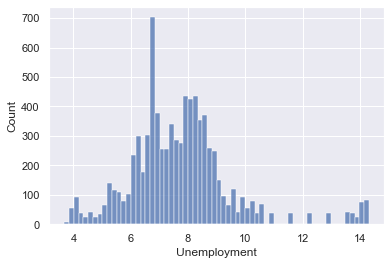

In [77]:
Unemployment_2013 = df_features.groupby(df_features['Date'].dt.year)['Unemployment'].mean().loc[2013]

df_features['Unemployment'] = df_features['Unemployment'].fillna(Unemployment_2013)

sns.histplot(df_features, x='Unemployment');

##### IsHoliday

In [78]:
df_features['IsHoliday'].value_counts()

False    7605
True      585
Name: IsHoliday, dtype: int64

There are no errors in is IsHoliday.

Let's export the clean data for later importing.

In [79]:
df_stores.to_csv('data-clean/stores.csv')
df_train.to_csv('data-clean/train.csv')
df_test.to_csv('data-clean/test.csv')
df_features.to_csv('data-clean/features.csv')

# Assignment 4: Explore the data
1.	Merge the dataframes in such a way you can use it for exploratory data analysis
2.	Play around with the data:
   
    a.	Plot the relations between each of the input variables and the output variable (sales).
    
    b.	Use statistics to identify significant variables and create relevant features.

    Do your analysis for the total and at least 3 stores and 3 departments.
    
## 4.1
Merge the dataframes in such a way you can use it for exploratory data analysis.

In [80]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [81]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [82]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


We can add the info of features and stores to the training data on: "Store", "Date" and "Holiday" for features and on "Store" again for stores.

In [83]:
df = df_train.merge(df_stores, on=['Store']).merge(df_features, on=['Store', 'Date', 'IsHoliday'])
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420207,45,93,2012-10-26,2487.80,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
420208,45,94,2012-10-26,5203.31,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
420209,45,95,2012-10-26,56017.47,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
420210,45,97,2012-10-26,6817.48,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667


## 4.2
Play around with the data:
   
- **a** Plot the relations between each of the input variables and the output variable (sales).
- **b.** Use statistics to identify significant variables and create relevant features
  Do your analysis for the total and at least 3 stores and 3 departments.
    
### All stores and departments

In [84]:
df.corr()[['Weekly_Sales']]

,Weekly_Sales
Store,-0.085117
Dept,0.148749
Weekly_Sales,1.000000
IsHoliday,0.012843
Size,0.244117
Temperature,-0.002339
Fuel_Price,0.000089
MarkDown1,0.085325
MarkDown2,0.024730
MarkDown3,0.060372


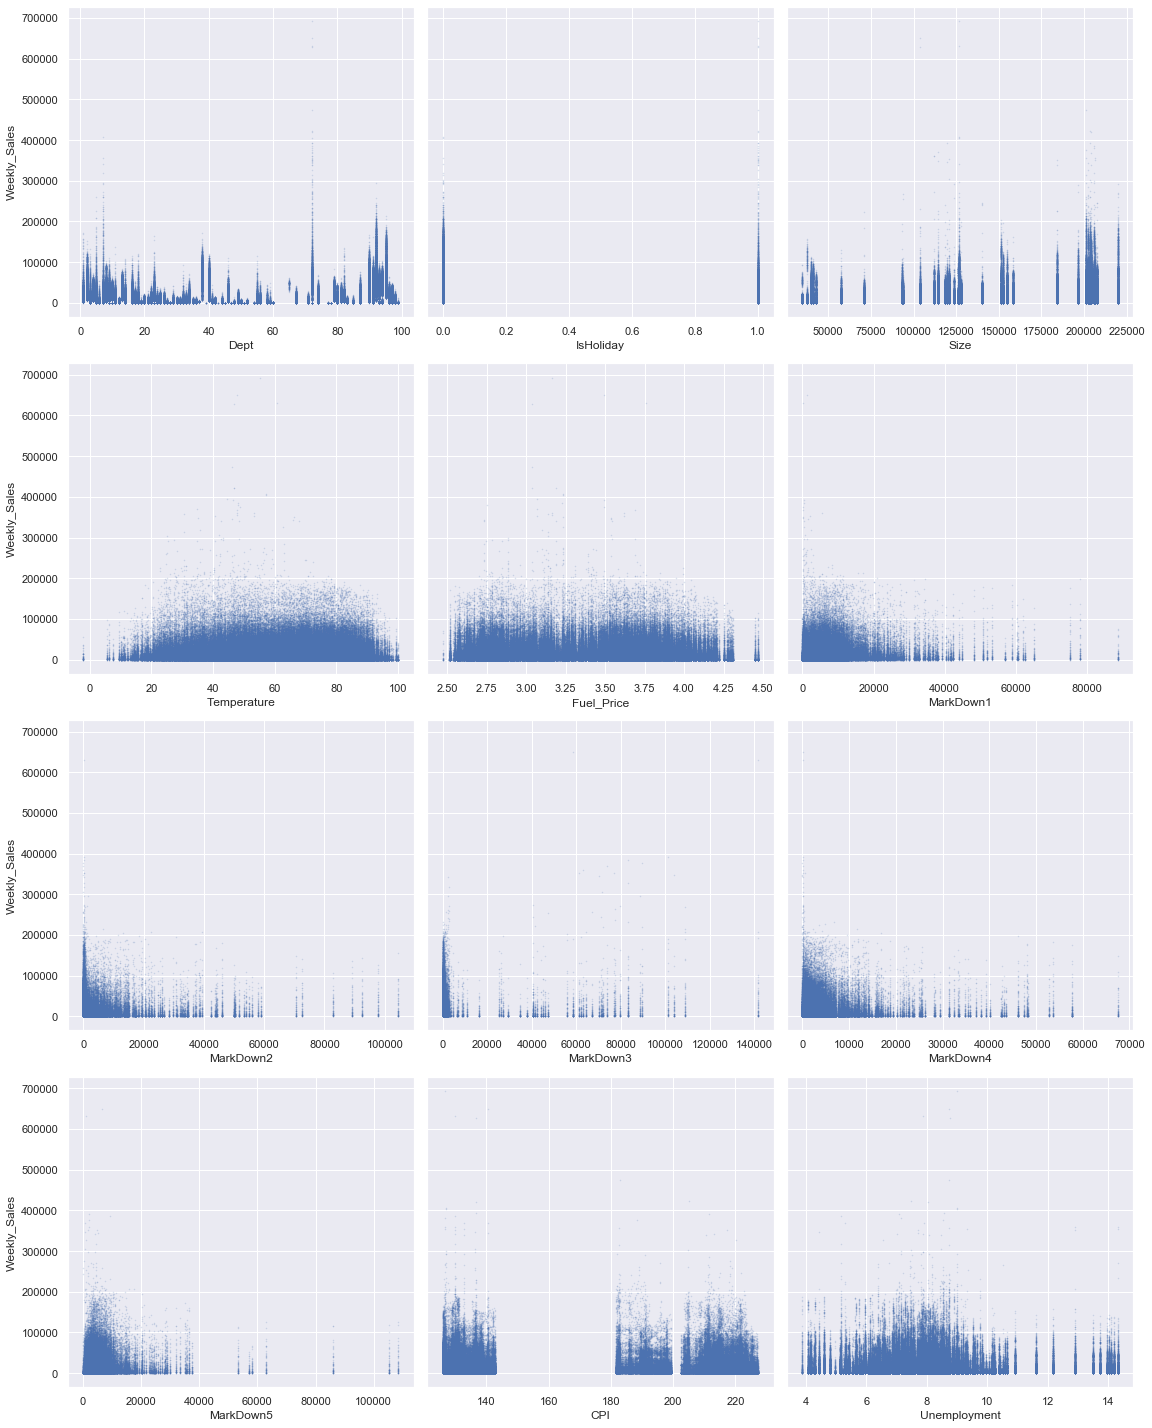

In [85]:
features = ['Dept', 'IsHoliday', 'Size', 
            'Temperature', 'Fuel_Price', 'MarkDown1', 
            'MarkDown2', 'MarkDown3', 'MarkDown4', 
            'MarkDown5', 'CPI', 'Unemployment']

fig, ax = plt.subplots(4, 3, figsize=(16,20), sharey=True)

index = 0
for i in range(4):
    ax[i][0].set_ylabel('Weekly_Sales')
    for j in range(3):
        ax[i][j].plot(df[features[index]], df['Weekly_Sales'], 'b.', alpha=0.2, markersize=1)
        ax[i][j].set_xlabel(features[index])
        ax[i][j].set_xlabel(features[index])
                
        index += 1
        
plt.tight_layout()

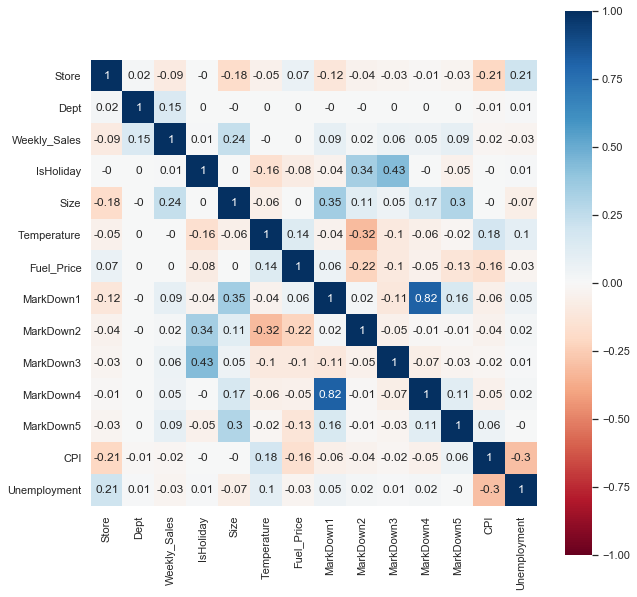

In [86]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(df.corr().round(2), cmap='RdBu', square=True, vmin=-1, vmax=1, annot=True, ax=ax);

According to the correlation matrix the scatterplots and the heatmap, the highest between Weekly_Sales and another variable is Size ($r=0.24$). All the MarkDown variables have a positive correlation to the Weekly_Sales.

In [87]:
# Plot functions for plotting dataframes of indiviudal stores and departments.

def scatter_plots(df):
    '''Creating scatter plots for features vs. weekly_sales in df'''
    
    features = ['IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 
                'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

    fig, ax = plt.subplots(2, 5, figsize=(16, 7), sharey=True)
    
    df_corr = df.corr()
    
    index = 0
    for i in range(2):
        ax[i][0].set_ylabel('Weekly_Sales')
        for j in range(5):
            ax[i][j].plot(df[features[index]], df['Weekly_Sales'], 'b.')
            ax[i][j].set_xlabel(features[index]) 
            ax[i][j].set_title(r'$r = {:.2f}$'.format(df_corr.at[features[index], 'Weekly_Sales']))

            index += 1

    plt.tight_layout()
    plt.close()
    
    return fig


def correlation_heatmap(df):
    '''Creating correlation heatmap for df excluding store and department.'''
    
    df_corr = df.corr().round(2).drop(['Store', 'Dept', 'Size']).drop(['Store', 'Dept', 'Size'], axis=1)
    
    fig, ax = plt.subplots(figsize=(10,9))
    
    sns.heatmap(df_corr, cmap='RdBu', square=True, vmin=-1, vmax=1, annot=True, ax=ax)
    fig.suptitle('Store {}, Department {}'.format(*df.iloc[0, [0, 1]].values))
    
    plt.tight_layout()
    plt.close()
    
    return fig

## Store 1 and Department 1

In [88]:
store_1_1 = df[(df['Store'] == 1) & (df['Dept'] == 1)]

store_1_1.corr()[['Weekly_Sales']].dropna()

,Weekly_Sales
Weekly_Sales,1.000000
IsHoliday,0.090061
Temperature,-0.473860
Fuel_Price,-0.066396
MarkDown1,-0.025236
MarkDown2,0.098830
MarkDown3,-0.022232
MarkDown4,0.014132
MarkDown5,-0.017468
CPI,-0.043533


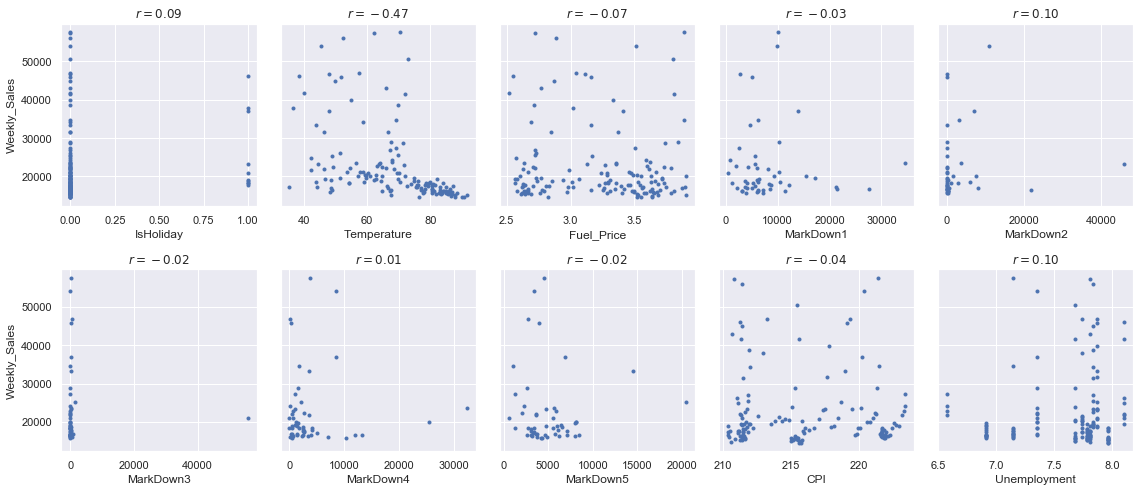

In [89]:
scatter_plots(store_1_1)

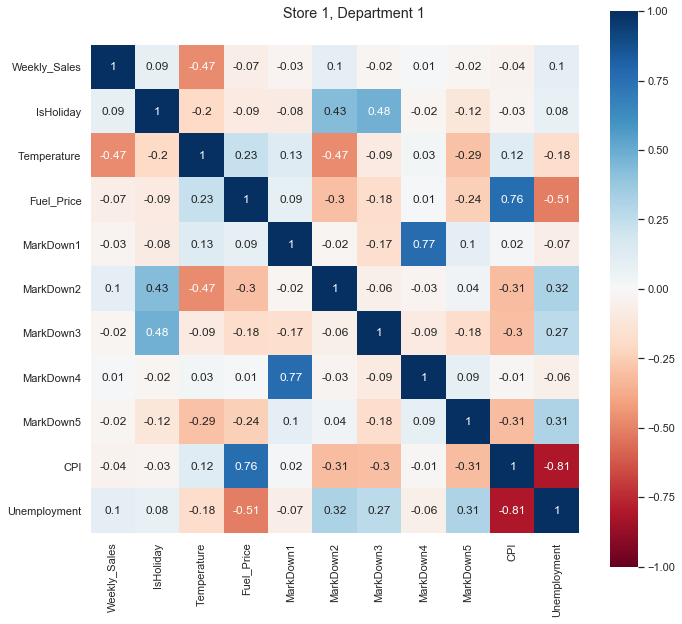

In [90]:
correlation_heatmap(store_1_1)

According to the correlation matrix the scatterplots and the heatmap, the highest between Weekly_Sales and another variable is Temperature ($r=-0.473$).

## Store 45 and Department 98

In [91]:
store_45_98 = df[(df['Store'] == 45) & (df['Dept'] == 98)]

store_45_98.corr()[['Weekly_Sales']].dropna()

,Weekly_Sales
Weekly_Sales,1.000000
IsHoliday,-0.047152
Temperature,0.095523
Fuel_Price,0.757083
MarkDown1,-0.110795
MarkDown2,-0.037203
MarkDown3,0.105391
MarkDown4,-0.045974
MarkDown5,-0.262456
CPI,0.568144


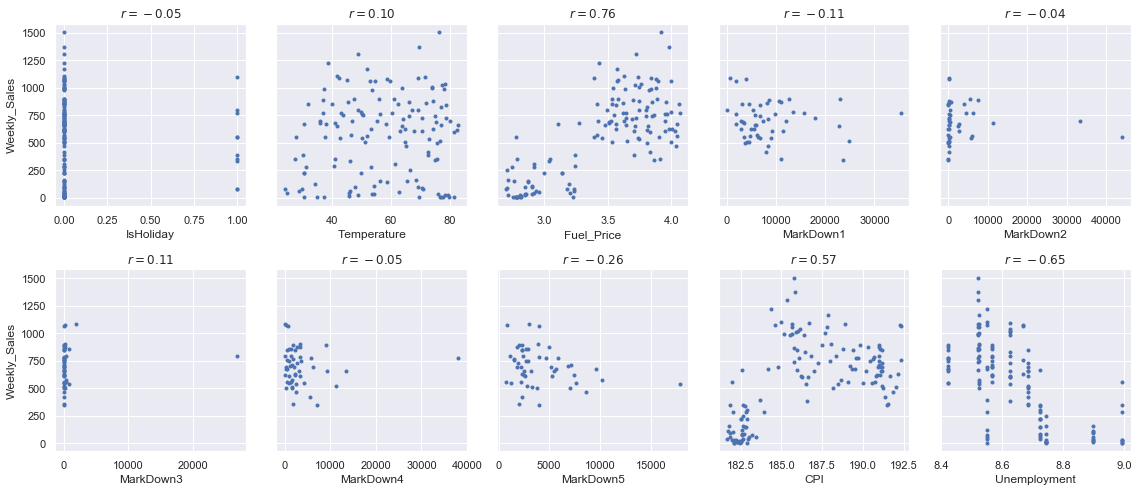

In [92]:
scatter_plots(store_45_98)

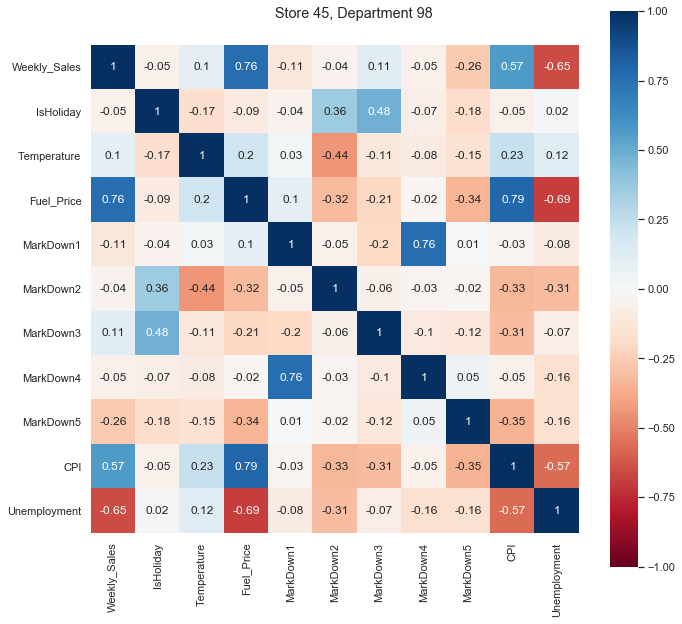

In [93]:
correlation_heatmap(store_45_98)

According to the correlation matrix the scatterplots and the heatmap, the highest between Weekly_Sales and another variable is Fuel_Price ($r=0.757$). Other significant variable are Unemployment ($r=-0.647$) and CPI ($r=0.568$).

## Store 22 and Department 38

In [94]:
df['Store'].median()

22.0

In [95]:
df['Dept'].median()

37.0

Store 22 doesn't have Dept 37 so let's take 38.

In [96]:
store_22_38 = df[(df['Store'] == 22) & (df['Dept'] == 38)]

store_22_38.corr()[['Weekly_Sales']].dropna()

,Weekly_Sales
Weekly_Sales,1.000000
IsHoliday,-0.151919
Temperature,-0.007229
Fuel_Price,0.531404
MarkDown1,0.092515
MarkDown2,0.058284
MarkDown3,-0.114658
MarkDown4,0.023167
MarkDown5,0.090805
CPI,0.589331


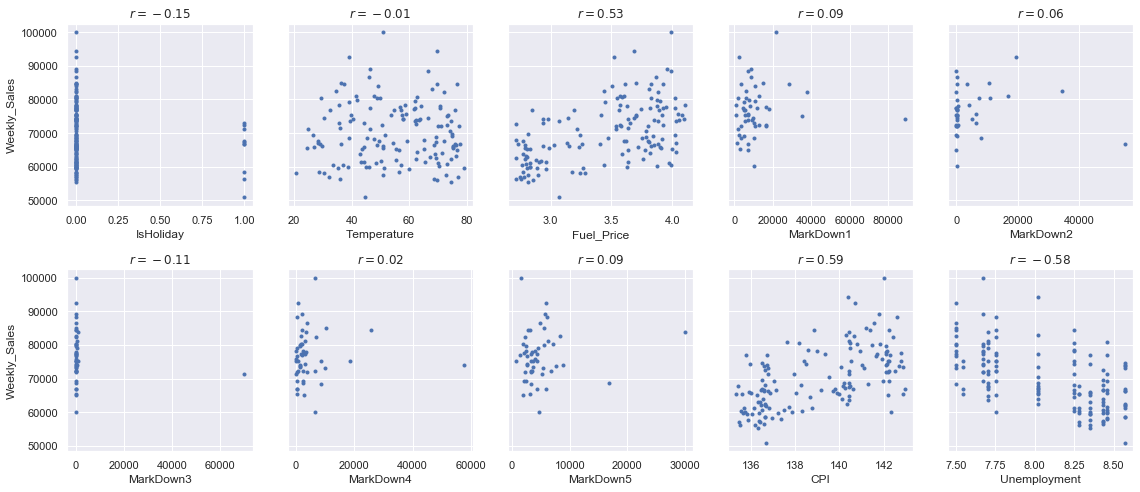

In [97]:
scatter_plots(store_22_38)

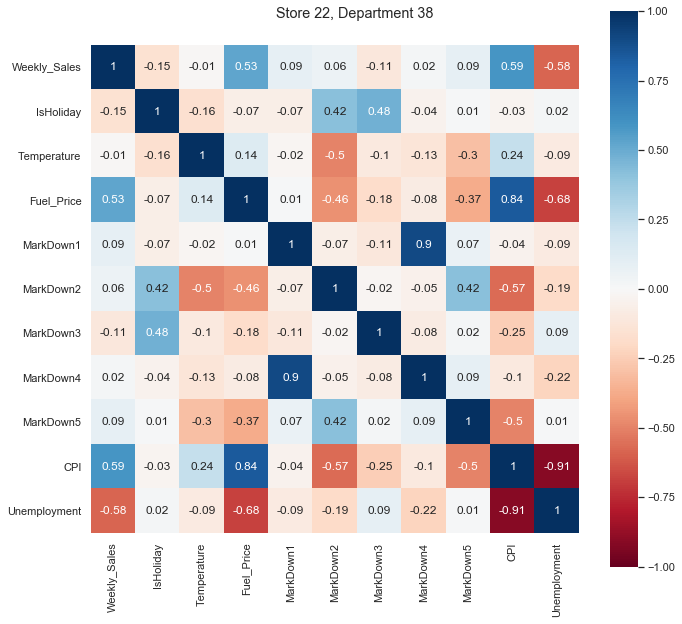

In [98]:
correlation_heatmap(store_22_38)

According to the correlation matrix the scatterplots and the heatmap, the highest between Weekly_Sales and another variable is CPI ($r=0.589$). Other significant variable are Unemployment ($r=-0.578$) and Fuel_Price ($r=0.531$).

#### Conclusion
The correlations between the independent variables and the Weekly_Sales are determined by Store (location) and Department (products). Especially the MarkDown variables seem to change correlation dramtically per department.

## Feature Engineering
### Extracting date features
We can't work with the date in machine learning models so we have to extract info like week, month and year from the dates.

In [99]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.week
df = df.sort_values(['Store', 'Dept', 'Date'])

In [100]:
df[['Store', 'Dept', 'Week', 'Year', 'Weekly_Sales']].head(145)

,Store,Dept,Week,Year,Weekly_Sales
0,1,1,5,2010,24924.50
73,1,1,6,2010,46039.49
145,1,1,7,2010,41595.55
217,1,1,8,2010,19403.54
289,1,1,9,2010,21827.90
...,...,...,...,...,...
10010,1,1,41,2012,22764.01
10083,1,1,42,2012,24185.27
10154,1,1,43,2012,27390.81
1,1,2,5,2010,50605.27


We also sort the values by first store, department and then date. Now we have per store the weekly sales of the department.

### MarkDown correlation per department
Let's take a closer look at the correlation of the MarkDown's with Weekly_Sales per Dept.

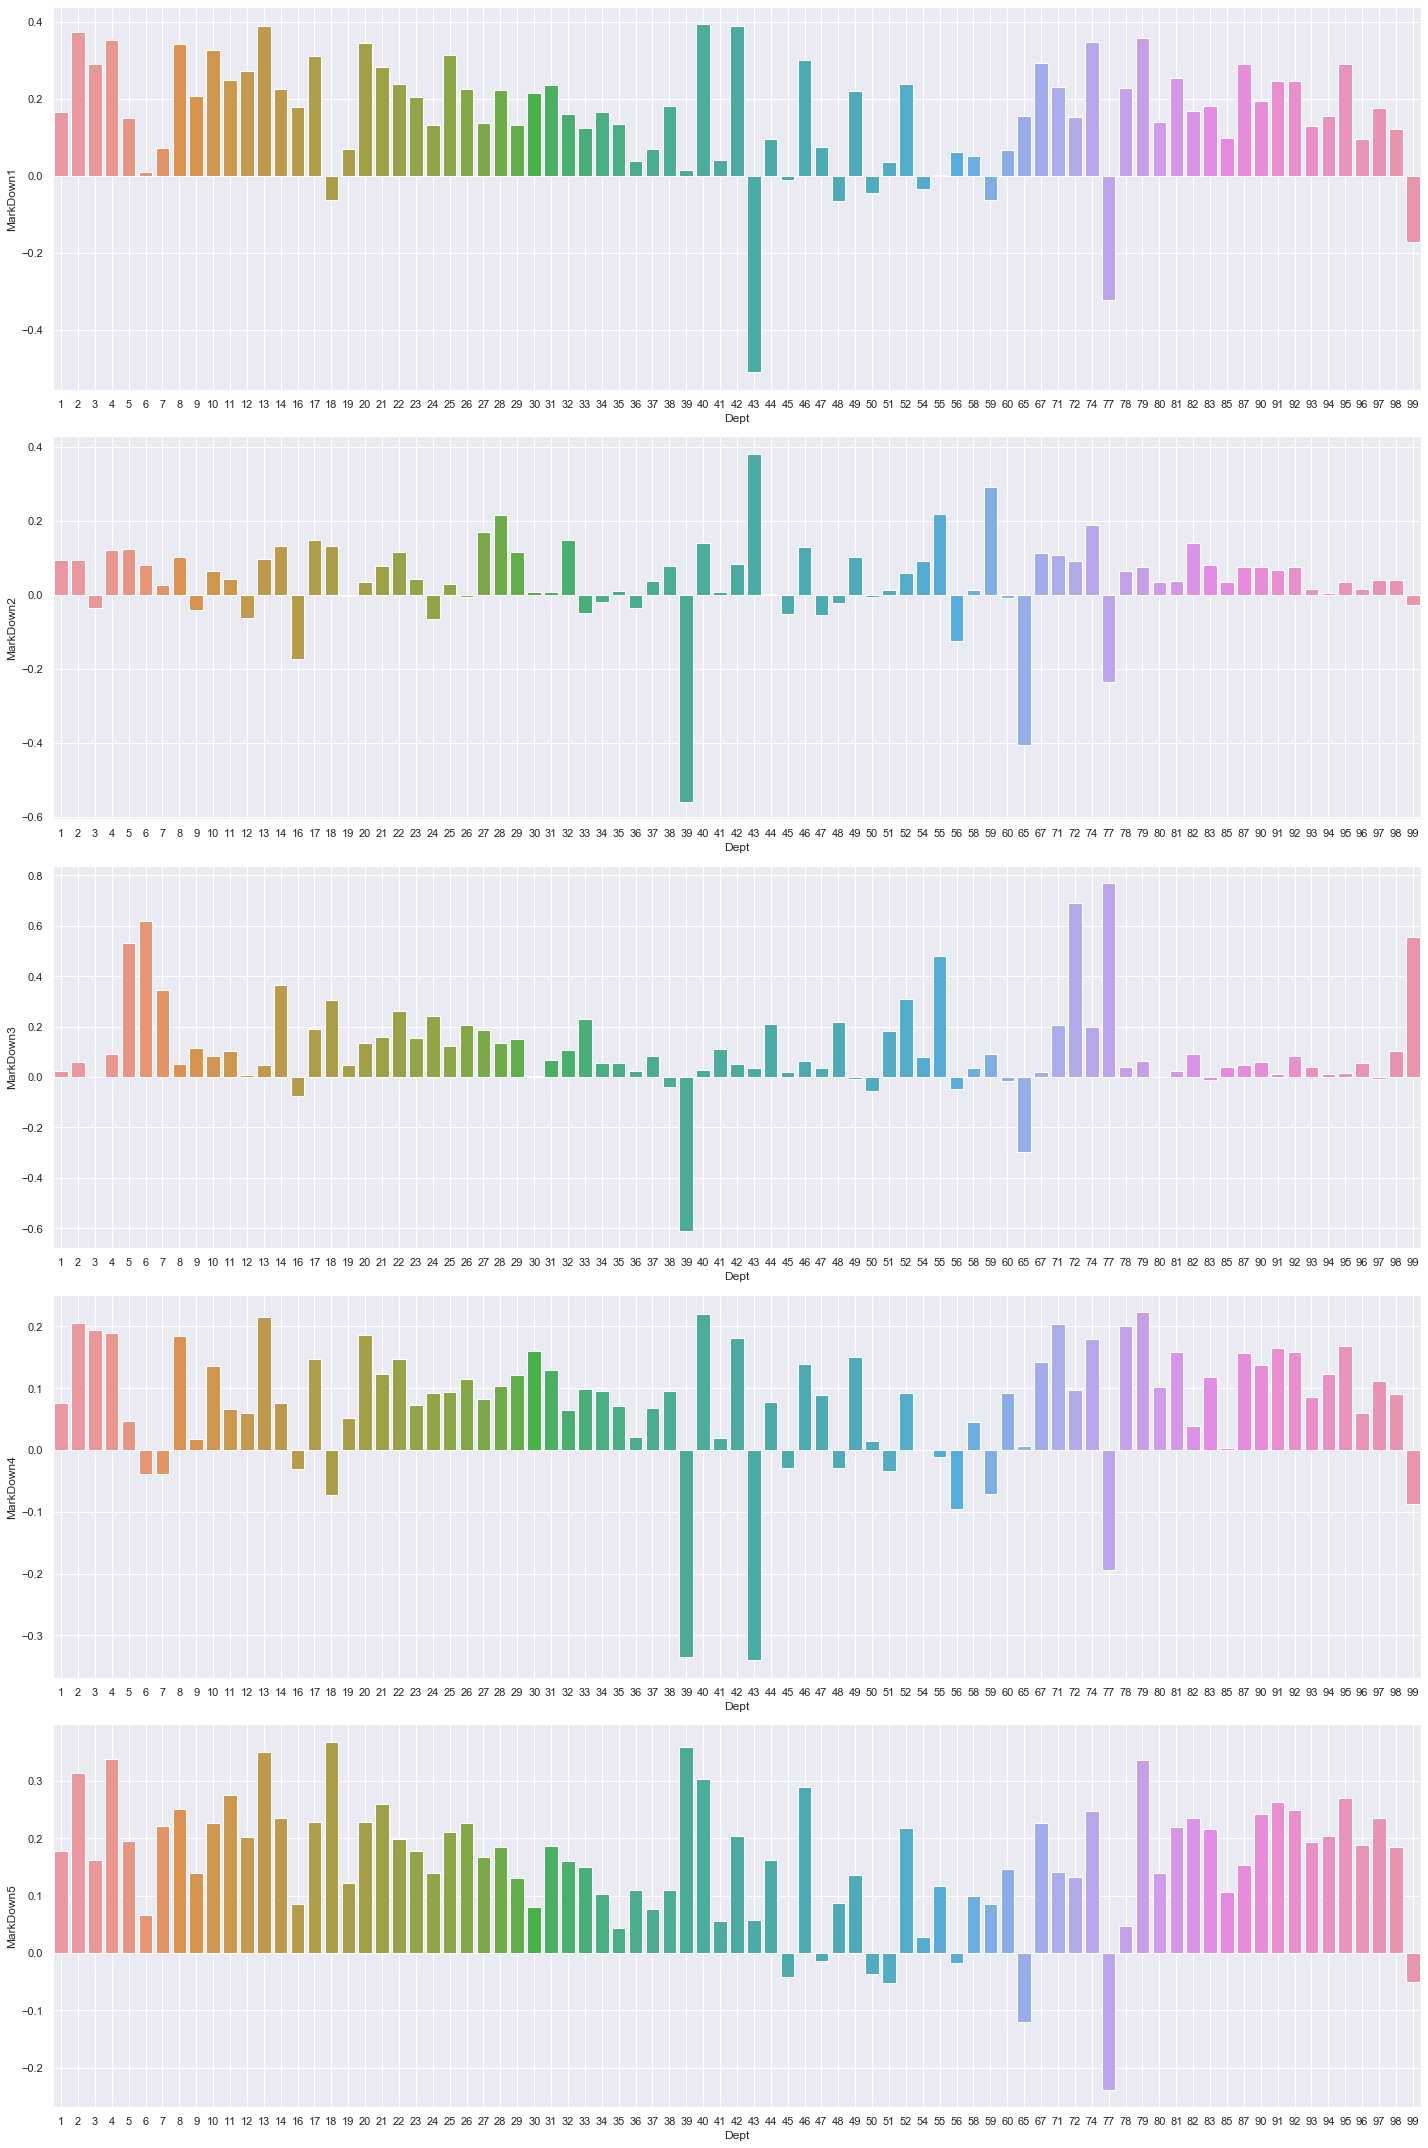

In [101]:
# getting the correlations of Weekly_Sales vs. the MarkDowns per departments
md_corr = [df.groupby('Dept')[['Weekly_Sales','MarkDown%i' %(i+1)]].corr()[::2].reset_index() for i in range(5)]

fig, ax = plt.subplots(5, 1, figsize=(20,30))

for i in range(5):
    sns.barplot(data=md_corr[i], x='Dept', y='MarkDown%i' %(i+1), ax=ax[i])
    ax[i].grid(True)
    
plt.tight_layout()
plt.show()

In [102]:
md_corr_median = [np.abs(c.iloc[:, -1]).median() for c in md_corr]

md_corr_median

[0.17870966840532448,
 0.06719714045837863,
 0.08050212800067337,
 0.0946419255373736,
 0.17744147838122085]

We can see that some of the departments shift direction in correlation. Also, some departments go from good correlation to no correlation in different markdowns and vice versa.

Let's create a function that can create dummy variables based on the direction of the correlation and if it surpasses a given threshold.

In [170]:
def markdown_significance_per_dept(df, corr_threshold=.1):
    '''Calculates the correlation of weekly_sales vs. the markdowns per dept and 
       returns if there is a significant positive or negative correlation'''
    # working from a copy of df so we can't affect the original
    dfc = df.copy(deep=True)
    # getting the correlations of Weekly_Sales vs. the MarkDowns per departments    
    md_corr = [dfc[dfc['MarkDown%i' %(i+1)] > 0].groupby('Dept')[['Weekly_Sales','MarkDown%i' %(i+1)]].corr()[::2].reset_index() for i in range(5)]
        
    # TODO Change reduce to pd.concat(dfs, axis=1)
    
    # combining the dfs containing the correlations per department in 1 df
    md_corr_df = reduce(
        lambda df_left, df_right: pd.merge(df_left, df_right,on='Dept'), 
        [c.drop(['level_1', 'Weekly_Sales'], axis=1) for c in md_corr]
    )
    
    # checking if 1 correlation threshold is given or 1 for every markdown
    if type(corr_threshold) not in [list, tuple, np.array]:
        corr_threshold = [corr_threshold] * md_corr_df.columns[1:].size
    
    # making the dummies, starting from i=1 because i=0 is dept
    for i, col in enumerate(md_corr_df.columns[1:]):
        # If the absolute correlation is above the threshold, 
        # the value is changed to -1 or 1 based on the direction, else 0.
        md_corr_df[col] = md_corr_df[col].apply(
            lambda x : str(int(x / np.abs(x))) if np.abs(x) > corr_threshold[i] else '0')
       
    # creating dummies for -1, 1, and 0
    MD_significance = pd.get_dummies(md_corr_df.drop('Dept', axis=1))
    # dropping the 0 dummies
    cols_to_drop = [c for c in MD_significance.columns if c[-1] == '0']    
    MD_significance = MD_significance.drop(cols_to_drop, axis=1)

    # join the departments back to the dummies
    MD_significance = md_corr_df[['Dept']].join(MD_significance)
        
    return MD_significance

In [160]:
markdown_significance_per_dept(df, corr_threshold=[0.2, 0.1, 0.1, 0.2, 0.2]).tail()

,Dept,MarkDown1_-1,MarkDown1_1,MarkDown2_-1,MarkDown2_1,MarkDown3_-1,MarkDown3_1,MarkDown4_-1,MarkDown4_1,MarkDown5_-1,MarkDown5_1
76,95,0,0,0,0,0,0,0,0,0,0
77,96,0,0,0,0,0,0,0,0,0,0
78,97,0,0,0,0,0,0,0,0,0,0
79,98,0,0,0,0,0,0,0,0,0,0
80,99,0,0,0,0,0,0,0,0,0,0


The results give us for what department a markdown gives a significant positive, negative, or no correlation. A single correlation threshold can be given or one per markdown.

### Lagged values
A general strategy for predicting timeseries values is lagging the target feature. We know the Sales for the current and past weeks, so we could use this information to predict the sales of tomorow.

In [6]:
def lag(df, offset=1):
    ''' Lagged values for sales with offset `offset`.'''
    # working from a copy of df so we can't affect the original
    dfc = df.copy(deep=True)
       
    # shifting the weekly sales by offset
    dfc['Lag{}'.format(offset)] = dfc['Weekly_Sales'].shift(offset)
    # initializing the isna col
    dfc['Lag{}_isna'.format(offset)] = 0
    
    print('\nlagged sales ( offset', offset, ')')
    sys.stdout.write('\r[{:<40}] store 0/45 0s'.format(''))
    t1 = time.time()
               
    for store in dfc['Store'].value_counts().sort_index().index:
        # for all the departments in store
        for dept in dfc['Dept'].value_counts().sort_index().index:
            try:
                # finding the indices where the dept starts
                for i in dfc[(dfc['Store'] == store) & (dfc['Dept'] == dept)].index[:offset]:
                    # setting the values for lag to 0 and isna to 1
                    dfc.at[i, 'Lag{}'.format(offset)] = 0
                    dfc.at[i, 'Lag{}_isna'.format(offset)] = 1
            
            # if department is not in store continue to next dept
            except IndexError:
                continue
            
        # progress bar
        sys.stdout.write('\r[{:<40}] store {}/45 {:.1f}s'.format('='*int(store/45*40), store, time.time()-t1))
        
    return dfc.iloc[:, -2:]

In [73]:
L = lag(df, offset=2)


lagged sales ( offset 2 )
[========================================] store 45/45 17.5s

In [74]:
L.columns

Index(['Lag2', 'Lag2_isna'], dtype='object')

Here we lagged the weekly sales by 2 weeks.

In [75]:
df[['Store','Dept','Week','Year','Weekly_Sales']].join(L).head(146)

,Store,Dept,Week,Year,Weekly_Sales,Lag2,Lag2_isna
0,1,1,5,2010,24924.50,0.00,1
73,1,1,6,2010,46039.49,0.00,1
145,1,1,7,2010,41595.55,24924.50,0
217,1,1,8,2010,19403.54,46039.49,0
289,1,1,9,2010,21827.90,41595.55,0
...,...,...,...,...,...,...,...
10083,1,1,42,2012,24185.27,21904.47,0
10154,1,1,43,2012,27390.81,22764.01,0
1,1,2,5,2010,50605.27,0.00,1
74,1,2,6,2010,44682.74,0.00,1


We can see now that the "Lag2" variable is lagging 2 weeks behind on the weekly sales.

### Rolling window
Another commonly used strategy with working with time series is a rolling window. Here we take a some function or value like the mean from the last 4 weeks for example.

In [7]:
def rolling_window(df, window_size=4, func=[np.mean]):
    ''' Rolling window for sales with window size `window_size` on functions `func[]`.'''   
    # working from a copy of df so we can't affect the original
    dfc = df.copy(deep=True)
    
    func_names = [str(f).split(' ')[1] for f in func]
    
    # initialize cols
    for j in range(len(func)):
        dfc['RW_Sales_' + func_names[j]] = 0.
    
    dfc['RW_Sales_isna'] = 0
    
    print('\nrolling window ( size', window_size, ')\nfunctions (', *func_names, ')')
    sys.stdout.write('\r[{:<40}] store 0/45 0s'.format(''))
    t1 = time.time()
    
    for store in dfc['Store'].value_counts().sort_index().index:
        for dept in dfc['Dept'].value_counts().sort_index().index:
            try:
                index = dfc[(dfc['Store'] == store) & (dfc['Dept'] == dept)].index
                for i in range(index.size - window_size):
                    for j in range(len(func)):
                        val = func[j](dfc.loc[index[i:i+window_size], 'Weekly_Sales'])
                        dfc.at[index[i+window_size], 'RW_Sales_' + func_names[j]] = val
                           
                dfc.at[index[:window_size], 'RW_Sales_isna'] = 1

            # if department is not in store continue to next dept
            except IndexError:
                continue
            
        # progress bar
        sys.stdout.write('\r[{:<40}] store {}/45 {:.1f}s'.format('='*int(store/45*40), store, time.time()-t1))
        
    # returning only the added columns
    return dfc.iloc[:,-len(func)-1:]

In [77]:
RW = rolling_window(df, window_size=4, func=[np.mean, np.median])


rolling window ( size 4 )
functions ( mean median )
[========================================] store 45/45 327.5s

In [78]:
RW.columns

Index(['RW_Sales_mean', 'RW_Sales_median', 'RW_Sales_isna'], dtype='object')

In [79]:
df[['Store','Dept','Week','Year','Weekly_Sales']].join(RW).head(145)

,Store,Dept,Week,Year,Weekly_Sales,RW_Sales_mean,RW_Sales_median,RW_Sales_isna
0,1,1,5,2010,24924.50,0.0000,0.000,1
73,1,1,6,2010,46039.49,0.0000,0.000,1
145,1,1,7,2010,41595.55,0.0000,0.000,1
217,1,1,8,2010,19403.54,0.0000,0.000,1
289,1,1,9,2010,21827.90,32990.7700,33260.025,0
...,...,...,...,...,...,...,...,...
10010,1,1,41,2012,22764.01,19930.0000,19433.860,0
10083,1,1,42,2012,24185.27,20716.9475,20577.985,0
10154,1,1,43,2012,27390.81,21950.3900,22334.240,0
1,1,2,5,2010,50605.27,0.0000,0.000,1


Here the rolling window contains the mean and the median of the past 4 weeks.

### Creating dummies for special holidays
Special dates where given by Walmart for the dates "IsHoliday" is `True`. We can create dummy variables for the different holidays to improve the model.

In [8]:
def holiday_dummies(df, holidays=['Christmas', 'Labor_Day', 'Super_Bowl', 'Easter', 'Black_Friday'], 
                    add_pre=['Christmas', 'Black_Friday']):
    
    # special dates for the holidays given by Walmart, easter is added
    DATES = {'Christmas': ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'], 
             'Labor_Day': ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
             'Super_Bowl': ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'],
             'Easter': ['2010-04-02', '2011-04-22', '2012-04-06', '2013-04-29'],
             'Black_Friday': ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']}
    # working from a copy of df so we can't affect the original
    dfc = df.copy(deep=True)

    for name, dates in DATES.items():
        if name in holidays:
            dfc[name] = dfc['Date'].isin(dates).astype(int)
    
    if 'Christmas' in add_pre:
        # christmas is always in week 52
        dfc['Pre_Christmas'] = (dfc['Week'] == 51).astype(int)
    if 'Black_Friday' in add_pre:
        # black_friday/thanksgiving is always in week 47
        dfc['Pre_Black_Friday'] = (dfc['Week'] == 46).astype(int)
        
    return dfc.iloc[:,-len(holidays + add_pre):]

In [81]:
holiday_dummies(df).columns

Index(['Christmas', 'Labor_Day', 'Super_Bowl', 'Easter', 'Black_Friday',
       'Pre_Christmas', 'Pre_Black_Friday'],
      dtype='object')

In [82]:
df[['Week', 'Year']].join(holiday_dummies(df))[df['IsHoliday']]

,Week,Year,Christmas,Labor_Day,Super_Bowl,Easter,Black_Friday,Pre_Christmas,Pre_Black_Friday
73,6,2010,0,0,1,0,0,0,0
2216,36,2010,0,1,0,0,0,0,0
3011,47,2010,0,0,0,0,1,0,0
3369,52,2010,1,0,0,0,0,0,0
3796,6,2011,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
416225,36,2011,0,1,0,0,0,0,0
416971,47,2011,0,0,0,0,1,0,0
417313,52,2011,1,0,0,0,0,0,0
417720,6,2012,0,0,1,0,0,0,0


### General Dummies
Generating dummies for given columns.

In [9]:
def make_dummies(df, cols=['Store', 'Dept', 'Type']):
    '''Creating dummies for given cols.'''
    # working from a copy of df so we can't affect the original
    dfc = df.copy(deep=True)
    
    n_cols = dfc.shape[1]
    
    for col in cols:
        dfc = dfc.join(pd.get_dummies(dfc[col], prefix=col))
        
    return dfc.iloc[:, n_cols:]

In [84]:
make_dummies(df)

,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
73,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
145,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
217,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
289,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
420012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
420078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
420144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


# Assigments 5
1.	Create a predictive model
    
    a.	Use the features that you found in assignment 4 and day, department and store
    
    b.	Use 3 types of model
    
2.	Evaluate and refine the model
    
    a.	You may have to revert back to steps 2 and 3
    
    b.	Choose the model you want to use
    
    c.	Improve the model using cross validation and/or a validation set.

In [10]:
def create_df(train=True, return_no_dummy=True):
    if train:
        base = pd.read_csv('data-clean/train.csv', parse_dates=['Date'], index_col=0)
    else:
        base = test = pd.read_csv('data-clean/test.csv', parse_dates=['Date'], index_col=0)
    
    stores = pd.read_csv('data-clean/stores.csv', index_col=0)
    features = pd.read_csv('data-clean/features.csv', parse_dates=['Date'], index_col=0)
    
    df = base.merge(stores, on=['Store']).merge(features, on=['Store', 'Date', 'IsHoliday'])
    df = df.sort_values(['Store', 'Dept', 'Date'])

    # spliting datetime object
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.week

    # fixing the nan's in the markdowns and creating dummy variables for when markdown isna
    for i in range(1, 6):
        df['md%i_isna' %i] = df['MarkDown%i' %i].isna()
    df.fillna(0, inplace=True)

    # creating dummies for cols in dummy_cols
    dummy_cols = ['Store', 'Dept', 'Type', 'IsHoliday', 'Week', 'Year', 'Month']
    dummies = make_dummies(df, cols=dummy_cols)

    # creating dummies for the holidays
    dummies_holiday = holiday_dummies(df)

    # keep a copy of the df without the dummies for easier to use filtering
    df_no_dummy = df.copy(deep=True)

    # joining the dummies for cols and dropping the original cols
    df = df.join(dummies).join(dummies_holiday)
    df = df.drop(['Date'] + dummy_cols, axis=1)
    
    # add dummies for all weeks, months and years if df is test
    if not train:
        for w in ['Week_%i' %i for i in range(1, 53)]:
            if not w in df.columns:
                df[w] = 0
        for m in ['Month_%i' %i for i in range(1, 13)]:
            if not m in df.columns:
                df[m] = 0
        for y in ['Year_%i' %i for i in range(2010, 2013)]:
            if not y in df.columns:
                df[y] = 0
        
    
    if return_no_dummy:
        return df, df_no_dummy
    else:
        return df

In [81]:
df, df_no_dummy = create_df(train=True, return_no_dummy=True)

In [86]:
L1 = lag(df, offset=1)
L2 = lag(df, offset=2)
L3 = lag(df, offset=3)
L4 = lag(df, offset=4)

RW = rolling_window(df, window_size=4, func=[np.mean, np.median, np.max, np.min, np.std, np.sum])

for i, L in enumerate([L1, L2, L3, L4]):
    L.to_csv('features/L%i.csv' %(i+1))
    
RW.to_csv('features/RW.csv')


lagged sales ( offset 1 )
[========================================] store 45/45 16.9s
lagged sales ( offset 2 )
[========================================] store 45/45 17.0s
lagged sales ( offset 3 )
[========================================] store 45/45 17.0s
lagged sales ( offset 4 )
[========================================] store 45/45 17.0s
rolling window ( size 4 )
functions ( mean median amax amin std sum )
[========================================] store 45/45 845.0s

In [11]:
L1 = pd.read_csv('features/L1.csv', index_col=0)
L2 = pd.read_csv('features/L2.csv', index_col=0)
L3 = pd.read_csv('features/L3.csv', index_col=0)
L4 = pd.read_csv('features/L4.csv', index_col=0)

RW = pd.read_csv('features/RW.csv', index_col=0)

In [162]:
def df_add_features(
        add_RW=['mean', 'median', 'std', 'amin', 'amax', 'sum'], 
        add_L=['L1', 'L2', 'L3', 'L4'],
        add_MD_significance=[0.2, 0.1, 0.1, 0.2, 0.2],
        is_train=False):
    '''Function for adding the rolling window, lagged cols, and markdown correlation significance features'''

    global RW, L1, L2, L3, L4
    
    df, df_no_dummy = create_df(train=True, return_no_dummy=True)
    
    dfc = df.copy(deep=True)
    
    L_dict = {'L1': L1, 'L2': L2, 'L3': L3, 'L4': L4, None:''}
    for L in add_L:
        dfc = dfc.join(L_dict[L])
        
    for func in add_RW:
        dfc = dfc.join(RW[['RW_Sales_' + func]])
    if add_RW != []:
        dfc = dfc.join(RW[['RW_Sales_isna']])
        
    if add_MD_significance != []:
        MD_significance = markdown_significance_per_dept(df_no_dummy, add_MD_significance)
                
        df_temp = df_no_dummy[['Dept']].reset_index().merge(MD_significance, on='Dept', how='left')
        df_temp = df_temp.set_index('index').drop('Dept', axis=1)
        
        dfc = dfc.join(df_temp)
    

    X = dfc.drop('Weekly_Sales', axis=1)
    y = dfc['Weekly_Sales']

    return X, y

In the kaggle competetion the score is calculated with a weighted mean absolute error (WMAE).

$$
\mathrm{WMAE} = \frac{1}{\sum{w}} \sum^{n}_{i=1}w_i |y_i - \hat{y}_i|
$$

The days where "IsHoliday" is `True` are weighted 5 times more than `False`.

In [13]:
def WMAE(X_test, y_test, y_hat):
    w = X_test['IsHoliday_True'].apply(lambda x: 5 if x else 1)
    
    wmae = 1 / np.sum(w) * np.sum(w * np.abs(y_test - y_hat))
    
    return wmae

## Trying different models
Training a some not including the rolling window, lagged, and markdown correlation significance features added to give use a quick overview of the most potential models. We're using a sample of the data to make training significant faster. 

In [25]:
X.columns[:20]

Index(['Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'md1_isna', 'md2_isna', 'md3_isna', 'md4_isna', 'md5_isna', 'Store_1',
       'Store_2', 'Store_3', 'Store_4', 'Store_5'],
      dtype='object')

In [30]:
X, y = df_add_features(add_RW=[], add_L=[], add_MD_significance=[])

cols_num = ['Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
            'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

from sklearn.preprocessing import StandardScaler

X[cols_num] = StandardScaler().fit_transform(X[cols_num])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

np.random.seed(3141592)
sample_frac = 1/3
Xs = X_train.sample(int(len(X_train) * sample_frac))
ys = y_train[Xs.index]

In [15]:
def score_overview(model):
    model.verbose = 0
    y_hat = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    wmae = WMAE(X_test, y_test, y_hat)
    mae = mean_absolute_error(y_test, y_hat)
    r2 = r2_score(y_test, y_hat)
    
    print(str(model)[:str(model).index('(')] + '\n' + '-'*40)
    
    for key, val in {'rmse':rmse,'wmae':wmae,'mae':mae,'r2':r2}.items():
        print(key, '\t|', val.round(2))

In [31]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


models = [LinearRegression, 
          ElasticNet,
          #SVR, 
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor,
          AdaBoostRegressor,
          MLPRegressor]

for Model in models:
    t1 = time.time()
    model = Model()
    
    if hasattr(model, 'n_jobs'):
        model.n_jobs = -1
    
    model.fit(Xs, ys)
    score_overview(model)
    print('time(s)\t|', round((time.time() - t1), 2))
    print('\n')

LinearRegression
----------------------------------------
rmse 	| 12950.48
wmae 	| 8354.72
mae 	| 8107.2
r2 	| 0.67
time(s)	| 2.17


ElasticNet
----------------------------------------
rmse 	| 21403.21
wmae 	| 14411.95
mae 	| 14235.47
r2 	| 0.09
time(s)	| 2.18


KNeighborsRegressor
----------------------------------------
rmse 	| 23597.25
wmae 	| 15821.06
mae 	| 15586.38
r2 	| -0.1
time(s)	| 30.38


DecisionTreeRegressor
----------------------------------------
rmse 	| 5541.2
wmae 	| 2428.55
mae 	| 2199.67
r2 	| 0.94
time(s)	| 8.66


RandomForestRegressor
----------------------------------------
rmse 	| 4444.49
wmae 	| 2033.1
mae 	| 1800.1
r2 	| 0.96
time(s)	| 14.05


AdaBoostRegressor
----------------------------------------
rmse 	| 44511.03
wmae 	| 42162.08
mae 	| 42238.55
r2 	| -2.92
time(s)	| 146.94




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor
----------------------------------------
rmse 	| 10065.14
wmae 	| 6064.62
mae 	| 5756.92
r2 	| 0.8
time(s)	| 77.59




In [99]:
def score_combinations(params, sample_frac=1.):    
    t1 = time.time()

    report = {
        'rmse': [],
        'wmae': [],
        'mae': [],
        'r2': [],
        'combination': [],
        'best_model': None,
        'best_combination': None,
        'sample_frac': sample_frac
    }
    
    add_features_params = {
        'add_RW': [],
        'add_L' : [],
        'add_MD_significance': []
    }

    sys.stdout.write('\r[{:<40}] combination {}/{} {:.1f}min'.format('', '0', len(list(params.values())[0]), 0.0))
    
    for i, combination in enumerate(list(params.values())[0]):
        add_features_params[list(params.keys())[0]] = combination
        
        X, y = df_add_features(**add_features_params)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

        reg = RandomForestRegressor(n_estimators=80, n_jobs=-1, random_state=42)

        np.random.seed(3141592)
        Xs = X_train.sample(int(len(X_train) * sample_frac))
        ys = y_train[Xs.index]

        reg.fit(Xs, ys)

        y_hat = reg.predict(X_test)

        report['rmse'].append(np.sqrt(mean_squared_error(y_test, y_hat)))
        report['wmae'].append(WMAE(X_test, y_test, y_hat))
        report['mae'].append(mean_absolute_error(y_test, y_hat))
        report['r2'].append(r2_score(y_test, y_hat))
        report['combination'].append(combination)
        
        if report['rmse'][-1] <= min(report['rmse']):
            report['best_model'] = reg
            report['best_combination'] = combination

        sys.stdout.write('\r[{:<40}] combination {}/{} {:.1f}min'.format(
            '='*int((i+1)/len(list(params.values())[0])*40), i+1, len(list(params.values())[0]), (time.time()-t1)/60))
    
    report['execution_time[min]'] = (time.time() - t1) / 60
    
    return report

In [100]:
def plot_report(report, x=[]):
    if len(x) == 0:
        fig, ax = plt.subplots(1, 3, figsize=(14, len(report['combination']) * 0.5))
    else:
        fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

    str_c = [[str(e) for e in c if e != None] for c in report['combination']]
    str_c = np.array([str(c).replace('[', '').replace(']','').replace("'", '') for c in str_c])

    errors = ['rmse', 'wmae', 'mae']

    for error in errors:
        report[error] = np.array(report[error])

    for i, error in enumerate(errors):
        if len(x) == 0:
            ax[i].barh(str_c[report['rmse'].argsort()], report[error][report['rmse'].argsort()])
            if i > 0:
                ax[i].set_yticklabels([])

            ax[i].set_title(error.upper())
            ax[i].set_xlim(min(report[error]) * 0.95, max(report[error]) * 1.05)
        else:
            ax[i].plot(x, report[error])
            ax[i].set_ylabel(error)

    fig.tight_layout()
    plt.close()
    
    return fig

In [101]:
def best_combination(report):
    best_i = report['combination'].index(report['best_combination'])

    print('best\t|', report['best_combination'])
    print('-'*20)
    for error in ['rmse', 'wmae', 'mae', 'r2']:
        print(error, '\t|', round(report[error][best_i], 2))

## Adding Lagged variables

In [102]:
params_L = [['L1', None], ['L2', None], ['L3', None], ['L4', None]]

combinations_L = list(product(*params_L))
combinations_L = [[f for f in combination if f != None] for combination in combinations_L][:-1]

combinations_L

[['L1', 'L2', 'L3', 'L4'],
 ['L1', 'L2', 'L3'],
 ['L1', 'L2', 'L4'],
 ['L1', 'L2'],
 ['L1', 'L3', 'L4'],
 ['L1', 'L3'],
 ['L1', 'L4'],
 ['L1'],
 ['L2', 'L3', 'L4'],
 ['L2', 'L3'],
 ['L2', 'L4'],
 ['L2'],
 ['L3', 'L4'],
 ['L3'],
 ['L4']]

In [103]:
report_lag = score_combinations({'add_L': combinations_L})

[========================================] combination 15/15 84.4min

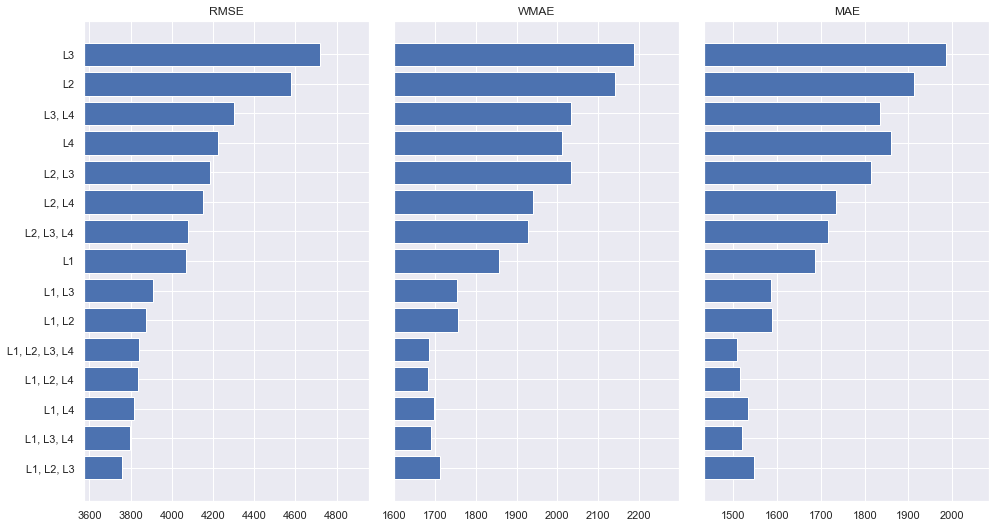

In [104]:
plot_report(report_lag)

In [105]:
best_i = combinations_L.index(report_lag['best_combination'])

for error in ['rmse', 'wmae', 'mae', 'r2']:
    print(error, '\t|', round(report_lag[error][best_i], 2))

rmse 	| 3760.22
wmae 	| 1712.72
mae 	| 1547.97
r2 	| 0.97


In [106]:
round(min(report_lag['wmae']), 2)

1683.63

## Adding Rolling Window

In [107]:
params_RW = [['mean', None], ['median', None], ['sum', None]]

combinations_RW = list(product(*params_RW))
combinations_RW = [[f for f in combination if f != None] for combination in combinations_RW][:-1]

combinations_RW

[['mean', 'median', 'sum'],
 ['mean', 'median'],
 ['mean', 'sum'],
 ['mean'],
 ['median', 'sum'],
 ['median'],
 ['sum']]

In [108]:
report_rolling_window = score_combinations({'add_RW': combinations_RW})

[========================================] combination 7/7 39.1min

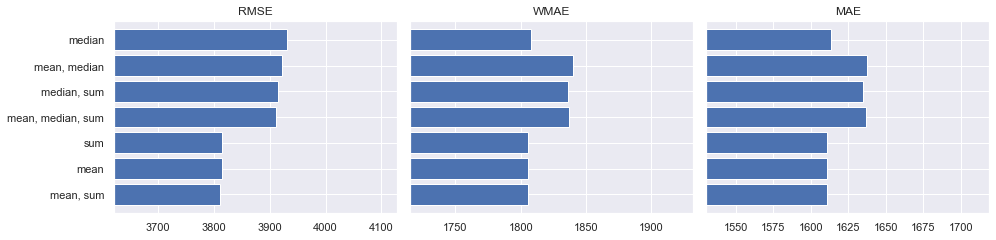

In [109]:
plot_report(report_rolling_window)

## Adding MarkDown significance

In [110]:
combinations_MD = [0.05, 0.1, 0.15, 0.2, 0.25]

combinations_MD

[0.05, 0.1, 0.15, 0.2, 0.25]

In [111]:
report_markdowns_full = score_combinations({'add_MD_significance': combinations_MD}, sample_frac=1)

[========================================] combination 5/5 22.3min

In [112]:
report_markdowns_sample = score_combinations({'add_MD_significance': combinations_MD}, sample_frac=1/3)

[========================================] combination 5/5 5.7min

In [113]:
full_vs_sample = np.array(report_markdowns_full['rmse']) / np.array(report_markdowns_sample['rmse'])

print('mean', full_vs_sample.mean().round(4) * 100, '%')

mean 80.65 %


In [114]:
print('std', full_vs_sample.std().round(4) * 100, '%')

std 0.4 %


In [115]:
best_i = combinations_MD.index(report_markdowns_full['best_combination'])

print('best\t|', report_markdowns_full['best_combination'])
print('-'*20)
for error in ['rmse', 'wmae', 'mae', 'r2']:
    print(error, '\t|', round(report_markdowns_full[error][best_i], 2))

best	| 0.15
--------------------
rmse 	| 3383.15
wmae 	| 1575.93
mae 	| 1416.73
r2 	| 0.98


In [116]:
best_i = combinations_MD.index(report_markdowns_sample['best_combination'])

print('best\t|', report_markdowns_sample['best_combination'])
print('-'*20)
for error in ['rmse', 'wmae', 'mae', 'r2']:
    print(error, '\t|', round(report_markdowns_sample[error][best_i], 2))

best	| 0.15
--------------------
rmse 	| 4201.03
wmae 	| 1944.75
mae 	| 1727.84
r2 	| 0.97


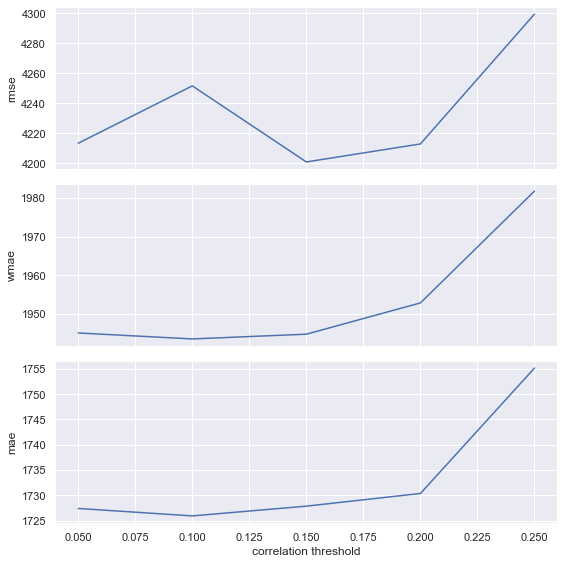

In [117]:
fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

for i, error in enumerate(['rmse', 'wmae', 'mae']):
    ax[i].plot(report_markdowns_sample['combination'], report_markdowns_sample[error])
    ax[i].set_ylabel(error)
    
ax[-1].set_xlabel('correlation threshold')
fig.tight_layout();

In [118]:
md_corr_median = np.array([md.iloc[:,-1].abs().median() for md in md_corr])
md_corr_median

array([0.17870967, 0.06719714, 0.08050213, 0.09464193, 0.17744148])

In [119]:
factors = np.arange(0.5, 2, 0.1).reshape(-1, 1)
factors

array([[0.5],
       [0.6],
       [0.7],
       [0.8],
       [0.9],
       [1. ],
       [1.1],
       [1.2],
       [1.3],
       [1.4],
       [1.5],
       [1.6],
       [1.7],
       [1.8],
       [1.9]])

In [120]:
combinations_MD = [list(r) for r in factors * md_corr_median]

In [121]:
report_markdowns_median = score_combinations({'add_MD_significance': combinations_MD}, sample_frac=1/3)

[========================================] combination 15/15 16.7min

In [122]:
best_combination(report_markdowns_median)

best	| [0.2680645026079867, 0.10079571068756793, 0.12075319200101003, 0.14196288830606038, 0.26616221757183123]
--------------------
rmse 	| 4188.49
wmae 	| 1937.78
mae 	| 1720.23
r2 	| 0.97


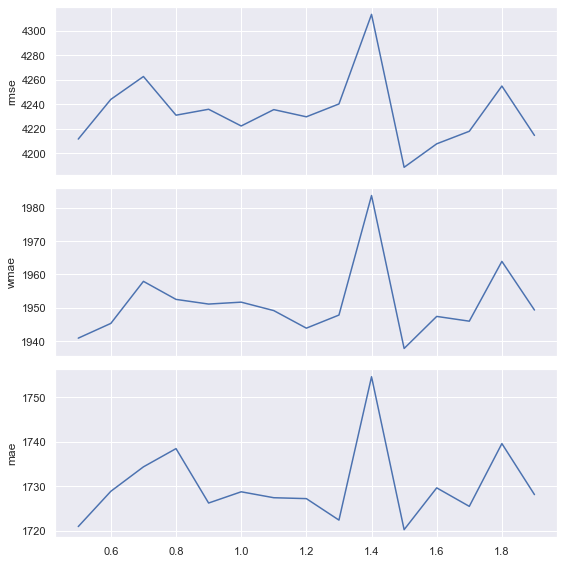

In [123]:
plot_report(report_markdowns_median, factors.ravel())

In [124]:
X, y = df_add_features(add_RW=[], add_L=[], add_MD_significance=[1.5 * md for md in md_corr_median])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

reg = RandomForestRegressor(n_estimators=80, n_jobs=-1, random_state=42, verbose=1)


np.random.seed(3141592)
sample_frac = 1.
Xs = X_train.sample(int(len(X_train) * sample_frac))
ys = y_train[Xs.index]

reg.fit(Xs, ys)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.5min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)

In [125]:
reg.verbose = 0

y_hat = reg.predict(X_test)

In [126]:
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
rmse

3429.0182416630264

In [127]:
wmae = WMAE(X_test, y_test, y_hat)
wmae

1584.4526029417787

In [128]:
mae = mean_absolute_error(y_test, y_hat)
mae

1422.7993639603342

In [129]:
r2 = r2_score(y_test, y_hat)
r2

0.9767281546439578

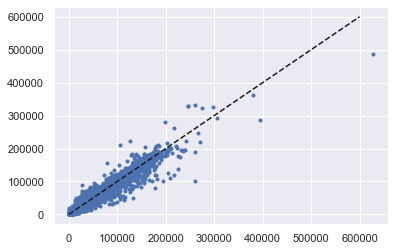

In [130]:
plt.plot(y_test, y_hat, '.')
plt.plot([0,600000], [0,600000], 'k--');

In [131]:
importance = pd.DataFrame(np.c_[X.columns, reg.feature_importances_], columns=['feature', 'importance'])
importance = importance.sort_values('importance', ascending=False)

importance.head(15)

,feature,importance
0,Size,0.205476
133,Dept_92,0.10575
136,Dept_95,0.0911689
96,Dept_38,0.0666672
228,MarkDown5_0,0.0457246
120,Dept_72,0.0429369
131,Dept_90,0.0348238
132,Dept_91,0.0252368
227,MarkDown4_1,0.0235867
24,Store_10,0.021302


In [135]:
joblib.dump(reg, 'model1.pkl')

['model1.pkl']

In [137]:
rf = RandomForestRegressor(
    random_state=42, 
    warm_start=True, 
    n_jobs=-1
)

rmse = []
wmae = []

error_up = 0

N_CORES = 6

for n_estimators in range(1, 300, N_CORES):
    rf.n_estimators = n_estimators
    rf.fit(Xs, ys)
    
    y_hat = rf.predict(X_test)
    
    rmse.append(np.sqrt(mean_squared_error(y_test, y_hat)))
    wmae.append(WMAE(X_test, y_test, y_hat))
    
    if wmae[-1] > min(wmae):
        error_up += 1
        if error_up == 3:
            break
            
    sys.stdout.write('\r{}'.format(n_estimators))

139

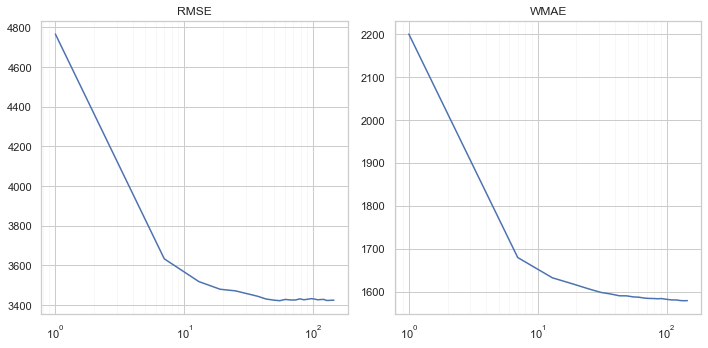

In [166]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].semilogx(np.arange(1, n_estimators+1, 6), rmse)
ax[1].semilogx(np.arange(1, n_estimators+1, 6), wmae)
ax[0].grid(True, which='minor', alpha=.15)
ax[1].grid(True, which='minor', alpha=.15)
ax[0].set_title('RMSE')
ax[1].set_title('WMAE')

fig.tight_layout()

In [178]:
rf = RandomForestRegressor(
    n_estimators=140,
    random_state=42,  
    n_jobs=-1
)

rmse_depth = []
wmae_depth = []

depth_space = [20, 25, 30, 35, 40, 50, 60, 70, 80]

for max_depth in depth_space:
    rf.max_depth = max_depth
    rf.fit(Xs, ys)
    
    y_hat = rf.predict(X_test)
    
    rmse_depth.append(np.sqrt(mean_squared_error(y_test, y_hat)))
    wmae_depth.append(WMAE(X_test, y_test, y_hat))
    
    sys.stdout.write('\r{}'.format(max_depth))

80

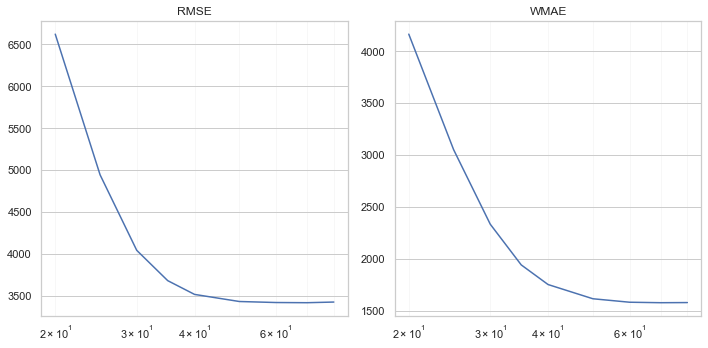

In [185]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].semilogx(depth_space, rmse_depth)
ax[1].semilogx(depth_space, wmae_depth)
ax[0].grid(True, which='minor', alpha=.15)
ax[1].grid(True, which='minor', alpha=.15)
ax[0].set_title('RMSE')
ax[1].set_title('WMAE')

fig.tight_layout()

In [188]:
depth_space[rmse_depth.index(min(rmse_depth))]

70

## Final Model

In [171]:
X, y = df_add_features(add_RW=[], add_L=[], add_MD_significance=[1.5 * md for md in md_corr_median])

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

np.random.seed(3141592)
sample_frac = 1.
Xs = X_train.sample(int(len(X_train) * sample_frac))
ys = y_train[Xs.index]

In [173]:
rf = RandomForestRegressor(
    n_estimators=140,
    max_depth=70,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf.fit(Xs, ys)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  7.9min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)

In [174]:
rf.verbose = 0

y_hat = rf.predict(X_test)

In [175]:
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
rmse

3416.5629162185687

In [176]:
wmae = WMAE(X_test, y_test, y_hat)
wmae

1577.0565500232642

In [177]:
mae = mean_absolute_error(y_test, y_hat)
mae

1418.4381019831803

In [178]:
r2 = r2_score(y_test, y_hat)
r2

0.976896909638264

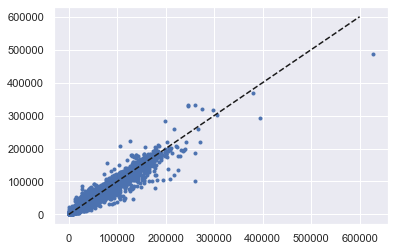

In [179]:
plt.plot(y_test, y_hat, '.')
plt.plot([0,600000], [0,600000], 'k--');

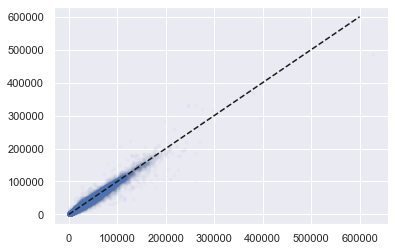

In [180]:
plt.plot(y_test, y_hat, '.', alpha=0.02)
plt.plot([0,600000], [0,600000], 'k--');

In [181]:
joblib.dump(rf, 'best_model.pkl')

['best_model.pkl']

## Sales Forecast

In [182]:
MD = markdown_significance_per_dept(create_df()[1], [1.5 * md for md in md_corr_median])

In [183]:
df_test, df_test_no_dummy = create_df(train=False)

df_temp = df_test_no_dummy[['Dept']].reset_index().merge(MD, on='Dept', how='left')
df_temp = df_temp.set_index('index').drop('Dept', axis=1)

X_TEST = df_test.join(df_temp).drop(['Year_2013'], axis=1)

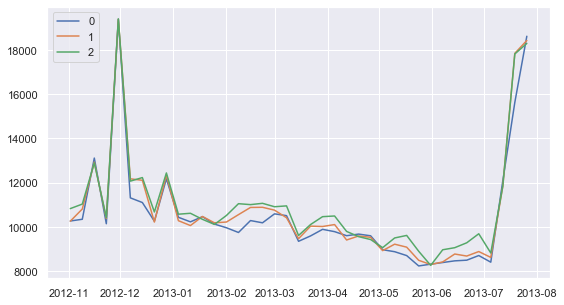

In [184]:
dept = 3
store = 1

idx = (df_test_no_dummy['Dept'] == dept) & (df_test_no_dummy['Store'] == store)

fig, ax = plt.subplots(figsize=(9,5))

for f in [0, 1, 2]:
    selected = X_TEST[idx].copy()
    
    selected[['MarkDown%i' %i for i in range(1, 6)]] = f * selected[['MarkDown%i' %i for i in range(1, 6)]]
    
    y_hat = rf.predict(selected)

    ax.plot(df_test_no_dummy.loc[idx, 'Date'], y_hat, label=f)
    
plt.legend()
plt.show()